In [35]:
from google.colab import drive #구글 드라이브 마운트를 위해 임폴드
drive.mount('/content/drive') #구글드라이브 마운트
import os #디렉토리 이동을 위해 임폴트
os.chdir('/content/drive/MyDrive/지하철 이용자수 예측을 통한 lstm 학습') #해당 위치에 csv파일들이 있어 이동

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
 #csv파일들 읽기
import pandas as pd
data_2018 = pd.read_csv('data_2018.csv')
data_2019 = pd.read_csv('data_2019.csv')
data_2020 = pd.read_csv('data_2020.csv', encoding = 'EUC-KR')#아래 파일들은 인코딩 방식이 다르다. euc-kr로 오픈하게 설정
data_2021 = pd.read_csv('data_2021.csv', encoding = 'EUC-KR')
data_2022 = pd.read_csv('data_2022.csv', encoding = 'EUC-KR')

<ipython-input-36-13eb1a81254d>:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data_2022 = pd.read_csv('data_2022.csv', encoding = 'EUC-KR')


In [37]:
stationName = '강남' #여러 역을 다루기엔 시간이 너무 오래 걸리는 관계로 강남역만 사용
df = data_2018[data_2018['역명'] == stationName]
df = pd.concat([df,data_2019[data_2019['역명'] == stationName]] , ignore_index=True)
df = pd.concat([df,data_2020[data_2020['역명'] == stationName]] , ignore_index=True)
df = pd.concat([df,data_2021[data_2021['역명'] == stationName]] , ignore_index=True)
df = pd.concat([df,data_2022[data_2022['역명'] == stationName]] , ignore_index=True)

df = df[df['구분'] == '승차'] #승차데이터만 사용
#df = df[df['호선'] == '2호선'] #2호선 강남역만 사용

df['날짜'] = pd.to_datetime(df['날짜']) # scv파일들의 날짜 형식이 통일되어있지 않다. 임의로 통일시킨다.

df #데이터 확인

,날짜,호선,역번호,역명,구분,05,06,07,08,09,...,17,18,19,20,21,22,23,00,합계,연번
0,2018-01-01,2호선,222,강남,승차,1284,1120,635,581,629,...,3355,3249,2819,3387,3958,4068,1860,2.0,39655.0,NaN
2,2018-01-02,2호선,222,강남,승차,404,828,1892,3214,2507,...,9694,16601,12402,8774,10318,9415,4263,856.0,116985.0,NaN
4,2018-01-03,2호선,222,강남,승차,477,796,2157,3222,2505,...,10464,17530,12111,8834,11087,11381,4953,1013.0,124651.0,NaN
6,2018-01-04,2호선,222,강남,승차,470,830,2055,3304,2501,...,10012,16660,12145,8910,11730,11726,5537,1200.0,125128.0,NaN
8,2018-01-05,2호선,222,강남,승차,477,822,1996,3159,2614,...,11096,17657,13127,9286,11167,12494,7905,2057.0,133271.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3642,2022-12-27,2,222,강남,승차,270,605,1598,2637,1932,...,9436,13001,8254,6288,7438,7124,3792,813.0,NaN,196419.0
3644,2022-12-28,2,222,강남,승차,291,631,1575,2426,1874,...,9562,12709,7899,6118,7634,7538,4153,865.0,NaN,196963.0
3646,2022-12-29,2,222,강남,승차,300,652,1386,2325,1791,...,9294,11927,7369,5971,7199,7350,4315,992.0,NaN,197509.0
3648,2022-12-30,2,222,강남,승차,309,560,1257,1909,1549,...,9195,9206,6187,4825,5675,5943,4014,980.0,NaN,198053.0


In [38]:
df = df.drop(columns=['호선', '역번호', '00', '합계', '연번']) # 사용하지않을 역번호, 합계, 연번, 00시이후 데이터 삭제

df #데이터 재확인

,날짜,역명,구분,05,06,07,08,09,10,11,...,14,15,16,17,18,19,20,21,22,23
0,2018-01-01,강남,승차,1284,1120,635,581,629,737,1070,...,2100,2606,2852,3355,3249,2819,3387,3958,4068,1860
2,2018-01-02,강남,승차,404,828,1892,3214,2507,2452,3014,...,5841,6891,7642,9694,16601,12402,8774,10318,9415,4263
4,2018-01-03,강남,승차,477,796,2157,3222,2505,2661,3514,...,6223,7141,7905,10464,17530,12111,8834,11087,11381,4953
6,2018-01-04,강남,승차,470,830,2055,3304,2501,2469,3426,...,6144,7124,8142,10012,16660,12145,8910,11730,11726,5537
8,2018-01-05,강남,승차,477,822,1996,3159,2614,2553,3518,...,6355,7429,8537,11096,17657,13127,9286,11167,12494,7905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3642,2022-12-27,강남,승차,270,605,1598,2637,1932,1888,2458,...,3892,5124,5947,9436,13001,8254,6288,7438,7124,3792
3644,2022-12-28,강남,승차,291,631,1575,2426,1874,1725,2400,...,4042,5164,5994,9562,12709,7899,6118,7634,7538,4153
3646,2022-12-29,강남,승차,300,652,1386,2325,1791,1800,2463,...,4002,5183,6143,9294,11927,7369,5971,7199,7350,4315
3648,2022-12-30,강남,승차,309,560,1257,1909,1549,1721,2468,...,5304,7032,7900,9195,9206,6187,4825,5675,5943,4014


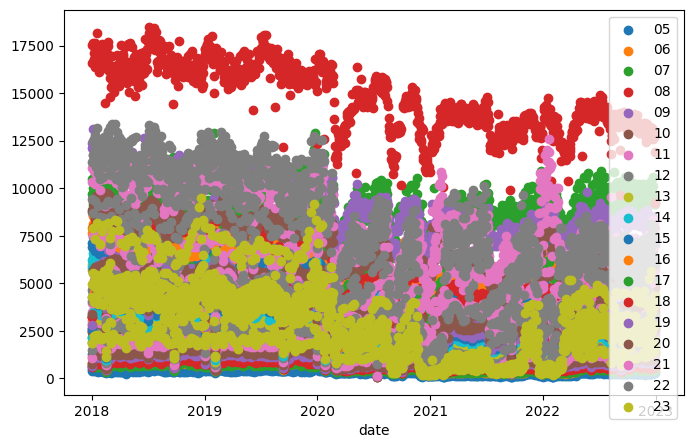

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

#데이터 전체출력하여 분포 확인
labels = ['05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']
fig = plt.figure(figsize=(8,5))
fig.set_facecolor('white')
for label in enumerate(labels):
  x = df['날짜']
  y = df[label[1]]
  plt.scatter(x=x, y=y, label=label[1])
  plt.xlabel('date')
  plt.legend()

In [40]:
#그래프를 알아볼 수 없어 다시 생성
#그래프 그리는 함수 생성
def set_axes(idx_x, idx_y):
    axes[idx_x,idx_y].scatter(y=df[labels[label_idx]], x=df['날짜'])
    axes[idx_x,idx_y].set_title(labels[label_idx])
    axes[idx_x,idx_y].set_xlabel('date', fontsize = 11)
    axes[idx_x,idx_y].set_ylabel('user', fontsize = 11)

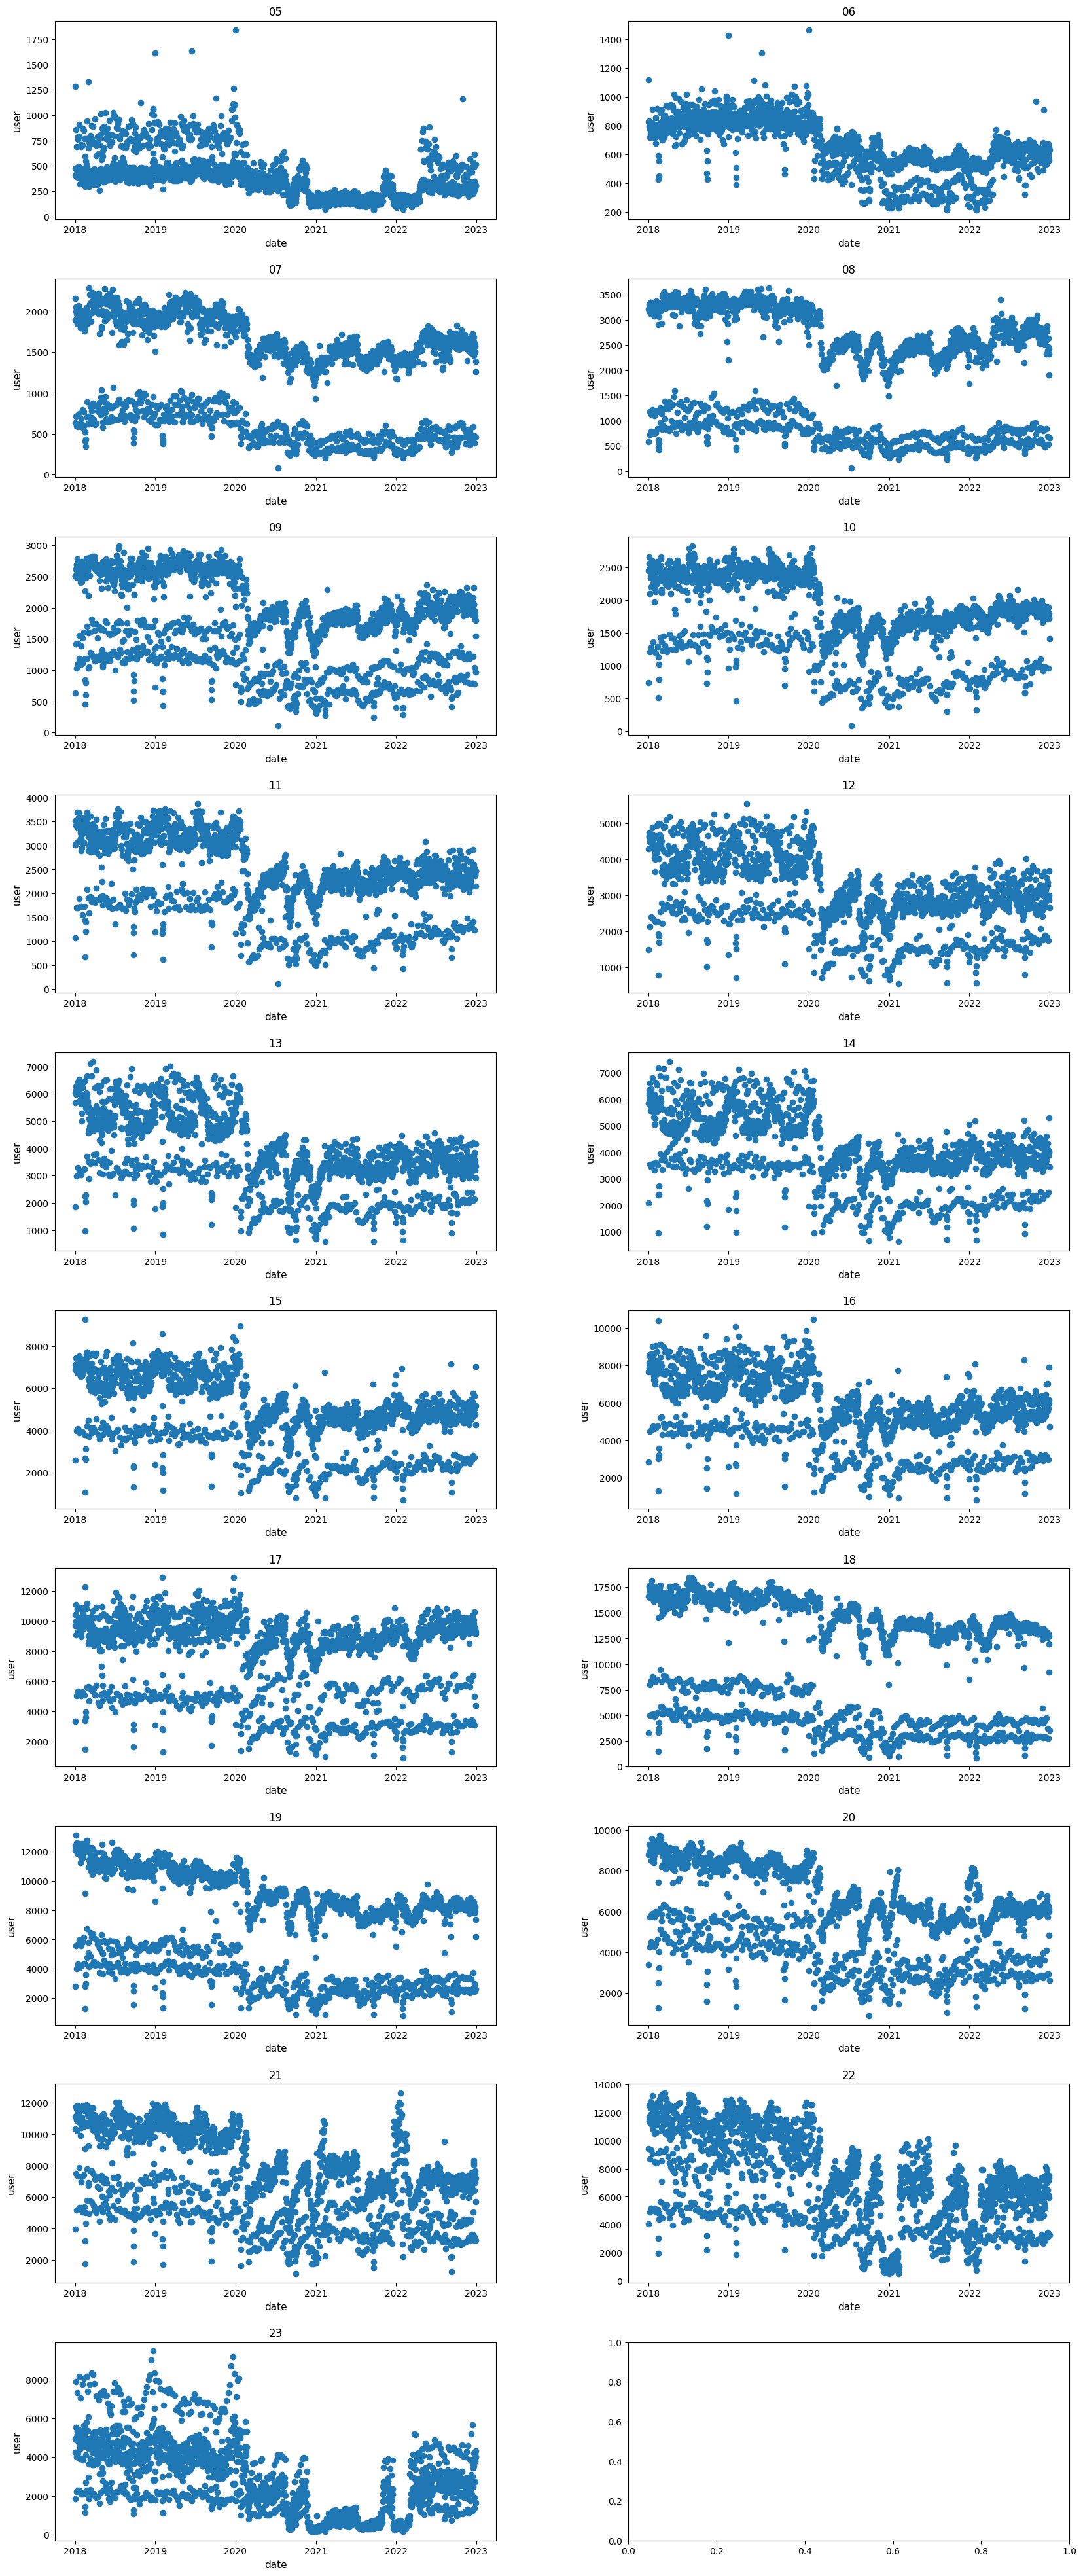

In [41]:
#10*2로 그래프 생성
fig, axes = plt.subplots(10,2)

#격자 크기 설정 및 여백 설정
fig.set_size_inches((20, 50))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

label_idx =0
k=0

#그래프 그리는 함수 호출
for i in range(19):
  if i%2 == 0:
    set_axes(k,0)
  else:
    set_axes(k,1)
    k+=1
  label_idx +=1

#그래프 보기
plt.show()

In [42]:
df.describe() #이상치 처리위해 통계 확인

,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23
count,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.00000,1826.000000,1826.000000,1826.000000
mean,390.961117,670.930997,1329.687295,2148.467689,1797.782585,1791.421687,2408.029573,3084.672508,3861.356517,4073.193319,4957.758488,5650.888280,7899.182366,11410.325301,7414.065717,5940.68839,7215.861446,6954.029573,2773.891566
std,214.678119,178.761121,584.065138,1038.625764,667.708598,547.554593,733.884746,945.605099,1309.209385,1240.359250,1496.835896,1677.208857,2509.593174,5110.532069,3099.550585,2008.72587,2551.679129,3173.505713,1873.219047
min,61.000000,214.000000,80.000000,58.000000,104.000000,75.000000,106.000000,540.000000,574.000000,624.000000,714.000000,829.000000,918.000000,858.000000,794.000000,885.00000,1117.000000,517.000000,164.000000
25%,222.250000,550.250000,739.250000,950.000000,1280.250000,1493.000000,2028.250000,2547.500000,3100.250000,3413.250000,4170.250000,4723.000000,6096.750000,5331.000000,4278.250000,4542.25000,5261.250000,4557.000000,1104.250000
50%,357.500000,662.000000,1485.500000,2466.500000,1840.500000,1763.500000,2367.500000,2944.000000,3561.000000,3878.000000,4826.000000,5565.000000,8836.000000,13392.500000,8138.500000,5968.50000,7069.000000,6753.500000,2489.000000
75%,471.750000,818.750000,1819.750000,3087.000000,2413.500000,2324.000000,3016.750000,3725.750000,4850.500000,4934.750000,6083.000000,6734.000000,9592.500000,15703.250000,10080.250000,7884.50000,9620.000000,9600.250000,4112.750000
max,1844.000000,1465.000000,2289.000000,3636.000000,2995.000000,2831.000000,3877.000000,5544.000000,7186.000000,7424.000000,9268.000000,10453.000000,12924.000000,18467.000000,13127.000000,9739.00000,12596.000000,13388.000000,9473.000000


<Axes: >

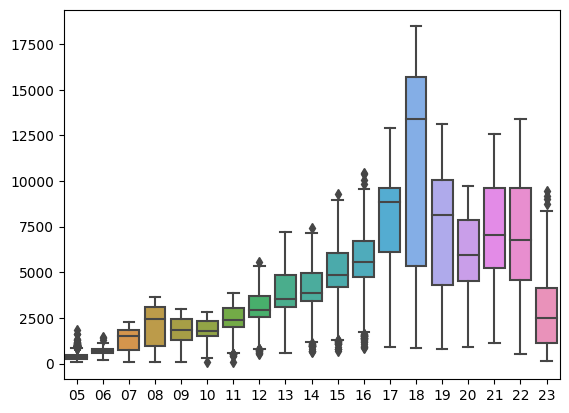

In [43]:
sns.boxplot(data=df) #그래프로 이상치 확인

In [44]:
#IQR방식 설명 링크 https://sseozytank.tistory.com/18
def detect_outliers (df ,columns): #이상치 제거 함수 IQR방식 으로 제거함
  q1=df[columns].quantile(0.25)
  q3=df [columns].quantile (0.75)

  iqr=q3-q1
  boundary= 1.5 *iqr

  index1=df[df[columns] > q3+boundary].index
  index2=df[df[columns] < q1-boundary].index

  df[columns]=df[columns].drop(index1)
  df[columns]=df[columns].drop(index2)

  return df

In [45]:
for label in enumerate(labels): #위에 만들어둔 라벨 이용해서 05 ~23 까지 이상치 제거
  detect_outliers(df, label[1])

df.describe() #통계 재확인

,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23
count,1741.000000,1823.000000,1826.000000,1826.000000,1826.000000,1825.000000,1817.000000,1813.000000,1826.000000,1808.000000,1808.000000,1797.000000,1826.000000,1826.000000,1826.000000,1826.00000,1826.000000,1826.000000,1822.000000
mean,362.540494,669.734504,1329.687295,2148.467689,1797.782585,1792.362192,2417.724821,3099.215113,3861.356517,4101.112832,4991.971239,5700.906511,7899.182366,11410.325301,7414.065717,5940.68839,7215.861446,6954.029573,2760.021405
std,171.862753,176.432984,584.065138,1038.625764,667.708598,546.227363,722.561519,926.700661,1309.209385,1205.111259,1452.083232,1596.716794,2509.593174,5110.532069,3099.550585,2008.72587,2551.679129,3173.505713,1851.654584
min,61.000000,214.000000,80.000000,58.000000,104.000000,302.000000,563.000000,784.000000,574.000000,1170.000000,1306.000000,1746.000000,918.000000,858.000000,794.000000,885.00000,1117.000000,517.000000,164.000000
25%,217.000000,550.000000,739.250000,950.000000,1280.250000,1493.000000,2038.000000,2562.000000,3100.250000,3426.500000,4193.750000,4760.000000,6096.750000,5331.000000,4278.250000,4542.25000,5261.250000,4557.000000,1101.250000
50%,346.000000,661.000000,1485.500000,2466.500000,1840.500000,1764.000000,2370.000000,2953.000000,3561.000000,3895.500000,4840.000000,5589.000000,8836.000000,13392.500000,8138.500000,5968.50000,7069.000000,6753.500000,2487.000000
75%,452.000000,818.000000,1819.750000,3087.000000,2413.500000,2324.000000,3021.000000,3730.000000,4850.500000,4940.000000,6089.250000,6735.000000,9592.500000,15703.250000,10080.250000,7884.50000,9620.000000,9600.250000,4101.000000
max,845.000000,1120.000000,2289.000000,3636.000000,2995.000000,2831.000000,3877.000000,5324.000000,7186.000000,7167.000000,8949.000000,9582.000000,12924.000000,18467.000000,13127.000000,9739.00000,12596.000000,13388.000000,8352.000000


<Axes: >

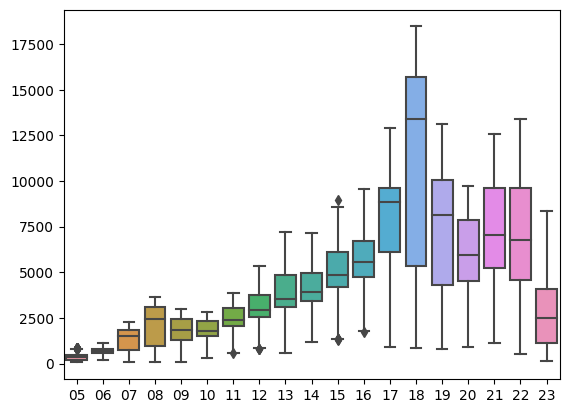

In [46]:
sns.boxplot(data=df) #이상치 삭제된 것 그래프로 재확인

In [47]:
df.isnull().any() #이상치가 삭제되어 데이터 중간중간 NaN이 들어있다. 이 경우 학습이 되지 않는다

날짜    False
역명    False
구분    False
05     True
06     True
07    False
08    False
09    False
10     True
11     True
12     True
13    False
14     True
15     True
16     True
17    False
18    False
19    False
20    False
21    False
22    False
23     True
dtype: bool

In [48]:
df = df.dropna() #이상치가 NaN으로 변경되어있으므로 NaN이 된 데이터들 삭제

In [49]:
df.isnull().any() #NaN이 있는지 확인. 없으므로 이제 데이터셋 준비가 완료되었다.

날짜    False
역명    False
구분    False
05    False
06    False
07    False
08    False
09    False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
dtype: bool

In [50]:
#lstm 으로 학습하기 위해서는 값이 0~1 사이어야 한다.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scale_cols = labels #정규화 컬럼은 위에 만들어둔 labels와 같다 05시 ~ 23시. 이름만 변경하여 사용

scaled_df = scaler.fit_transform(df[scale_cols]) #정규화 진행
#print(type(scaled_df), '\n') #type확인

scaled_df = pd.DataFrame(scaled_df, columns = scale_cols) #DataFrame형식으로 변경
#print(type(scaled_df), '\n') #type확인
#print(scaled_df) #데이터 확인

In [51]:
#학습을 위해 데이터셋 만들기
times = labels # 05시~23시의 데이터 셋 생성

feature_cols = [0] * 24
label_cols = [0] * 24
label_df = [0] * 24
feature_df = [0] * 24
label_np = [0] * 24
feature_np = [0] * 24

#feature_ 로 시작하는것은 입력데이터
#label_ 로 시작하는것은 정답데이터

for time in enumerate(times): # 05시부터 23시까지 입력 데이터 및 정답데이터 생성 0~4까지는 버리고 5부터 시작한다
  feature_cols[int(time[1])] = [str(time[1])] # 데이터프레임 생성을 위해 컬럼명 넣어주기 05~23값이 들어간다
  label_cols[int(time[1])] = [str(time[1])] # 데이터프레임 생성을 위해 컬럼명 넣어주기 05~23값이 들어간다

  #DataFrame형식으로 변환
  #위에서 정규화 시킨 데이터들(scaled_df)과 방금 생성한 컬럼명을 이용하여 DataFrame형식으로 변경해준다
  feature_df[int(time[1])] = pd.DataFrame(scaled_df, columns=feature_cols[int(time[1])])
  label_df[int(time[1])] = pd.DataFrame(scaled_df, columns= label_cols[int(time[1])])

  #numpy형식으로 변환
  feature_np[int(time[1])] = feature_df[int(time[1])].to_numpy()
  label_np[int(time[1])] = label_df[int(time[1])].to_numpy()


In [ ]:
#데이터 확인
#print(feature_df)
#print(label_df)

In [52]:
# 데이터를 넘파이 형식으로 변환
# 입력 파라미터 feature, label => numpy type
import numpy as np

def make_sequene_dataset(feature, label, window_size):
    feature_list = []      # 생성될 입력 list
    label_list = []        # 생성될 정답 list

    for i in range(len(feature)-window_size):
        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])

    return np.array(feature_list), np.array(label_list)

In [53]:
window_size = 30 #window_size 의 값으로 다음 값을 예측한다

X = [0] * 24
Y = [0] * 24

for time in enumerate(times): #5시 ~ 23시 데이터 셋 만들어주기
  X[int(time[1])],Y[int(time[1])] = make_sequene_dataset(feature_np[int(time[1])], label_np[int(time[1])], window_size)
  print(time[1],X[int(time[1])].shape, Y[int(time[1])].shape)


05 (1676, 30, 1) (1676, 1)
06 (1676, 30, 1) (1676, 1)
07 (1676, 30, 1) (1676, 1)
08 (1676, 30, 1) (1676, 1)
09 (1676, 30, 1) (1676, 1)
10 (1676, 30, 1) (1676, 1)
11 (1676, 30, 1) (1676, 1)
12 (1676, 30, 1) (1676, 1)
13 (1676, 30, 1) (1676, 1)
14 (1676, 30, 1) (1676, 1)
15 (1676, 30, 1) (1676, 1)
16 (1676, 30, 1) (1676, 1)
17 (1676, 30, 1) (1676, 1)
18 (1676, 30, 1) (1676, 1)
19 (1676, 30, 1) (1676, 1)
20 (1676, 30, 1) (1676, 1)
21 (1676, 30, 1) (1676, 1)
22 (1676, 30, 1) (1676, 1)
23 (1676, 30, 1) (1676, 1)


In [54]:
split =  -30 # 0~(n-split)까지는 학습 데이터로 사용하고 (split~n) ~ 마지막데이터 까지는 정답 데이터로 사용한다

x_train = [0] * 24
y_train = [0] * 24
x_test = [0] * 24
y_test = [0] * 24

for time in enumerate(times):   #for 문으로 05시부터 23시까지 학습
  x_train[int(time[1])] = X[int(time[1])][0:split]
  y_train[int(time[1])] = Y[int(time[1])][0:split]

  x_test[int(time[1])] = X[int(time[1])][split:]
  y_test[int(time[1])] = Y[int(time[1])][split:]

  print(time[1],' train_data',x_train[int(time[1])].shape, y_train[int(time[1])].shape,'  test_data', x_test[int(time[1])].shape, y_test[int(time[1])].shape)

05  train_data (1646, 30, 1) (1646, 1)   test_data (30, 30, 1) (30, 1)
06  train_data (1646, 30, 1) (1646, 1)   test_data (30, 30, 1) (30, 1)
07  train_data (1646, 30, 1) (1646, 1)   test_data (30, 30, 1) (30, 1)
08  train_data (1646, 30, 1) (1646, 1)   test_data (30, 30, 1) (30, 1)
09  train_data (1646, 30, 1) (1646, 1)   test_data (30, 30, 1) (30, 1)
10  train_data (1646, 30, 1) (1646, 1)   test_data (30, 30, 1) (30, 1)
11  train_data (1646, 30, 1) (1646, 1)   test_data (30, 30, 1) (30, 1)
12  train_data (1646, 30, 1) (1646, 1)   test_data (30, 30, 1) (30, 1)
13  train_data (1646, 30, 1) (1646, 1)   test_data (30, 30, 1) (30, 1)
14  train_data (1646, 30, 1) (1646, 1)   test_data (30, 30, 1) (30, 1)
15  train_data (1646, 30, 1) (1646, 1)   test_data (30, 30, 1) (30, 1)
16  train_data (1646, 30, 1) (1646, 1)   test_data (30, 30, 1) (30, 1)
17  train_data (1646, 30, 1) (1646, 1)   test_data (30, 30, 1) (30, 1)
18  train_data (1646, 30, 1) (1646, 1)   test_data (30, 30, 1) (30, 1)
19  tr

In [55]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def makeModel(shape): # 모델 생성 함수
  model = Sequential()

  model.add(LSTM(128, activation='tanh', input_shape=shape)) #lstm 모델을 생성
  model.add(Dense(1,activation='linear'))

  model.summary()
  return model

In [ ]:
#model05 ~ model23까지 반복해서 생성
for time in enumerate(times):
  globals()['model{}'.format(time[1])] = makeModel(x_train[int(time[1])][0].shape)

In [57]:
from tensorflow.keras.callbacks import EarlyStopping

def modelFit(model, num): #모델 학습 함수
  print(model, num)
  model.compile(loss='mse', optimizer='adam', metrics=['mae'])

  early_stop = EarlyStopping(monitor='val_loss', patience=5)

  model.fit(x_train[num], y_train[num], validation_data=(x_test[num],y_test[num]), epochs=100, batch_size = 16, callbacks=[early_stop])


In [ ]:
#5시~23시 까지 모델을 학습시킴
for time in enumerate(times):
  modelFit((eval('model'+str(time[1]))),int(time[1]))

In [59]:
#그래프 그리는 함수 생성
def setPredictGraph(idx_x, idx_y, time):
  model = eval('model'+str(labels[time-5]))
  pred = model.predict(x_test[time])

  axes[idx_x,idx_y].plot(y_test[int(time)], label='actual')
  axes[idx_x,idx_y].plot(pred, label='prediction')
  axes[idx_x,idx_y].set_title('predict at '+ str(time))
  axes[idx_x,idx_y].set_xlabel('period', fontsize = 11)
  axes[idx_x,idx_y].set_ylabel('user', fontsize = 11)

1/1 [==============================] - 0s 327ms/step


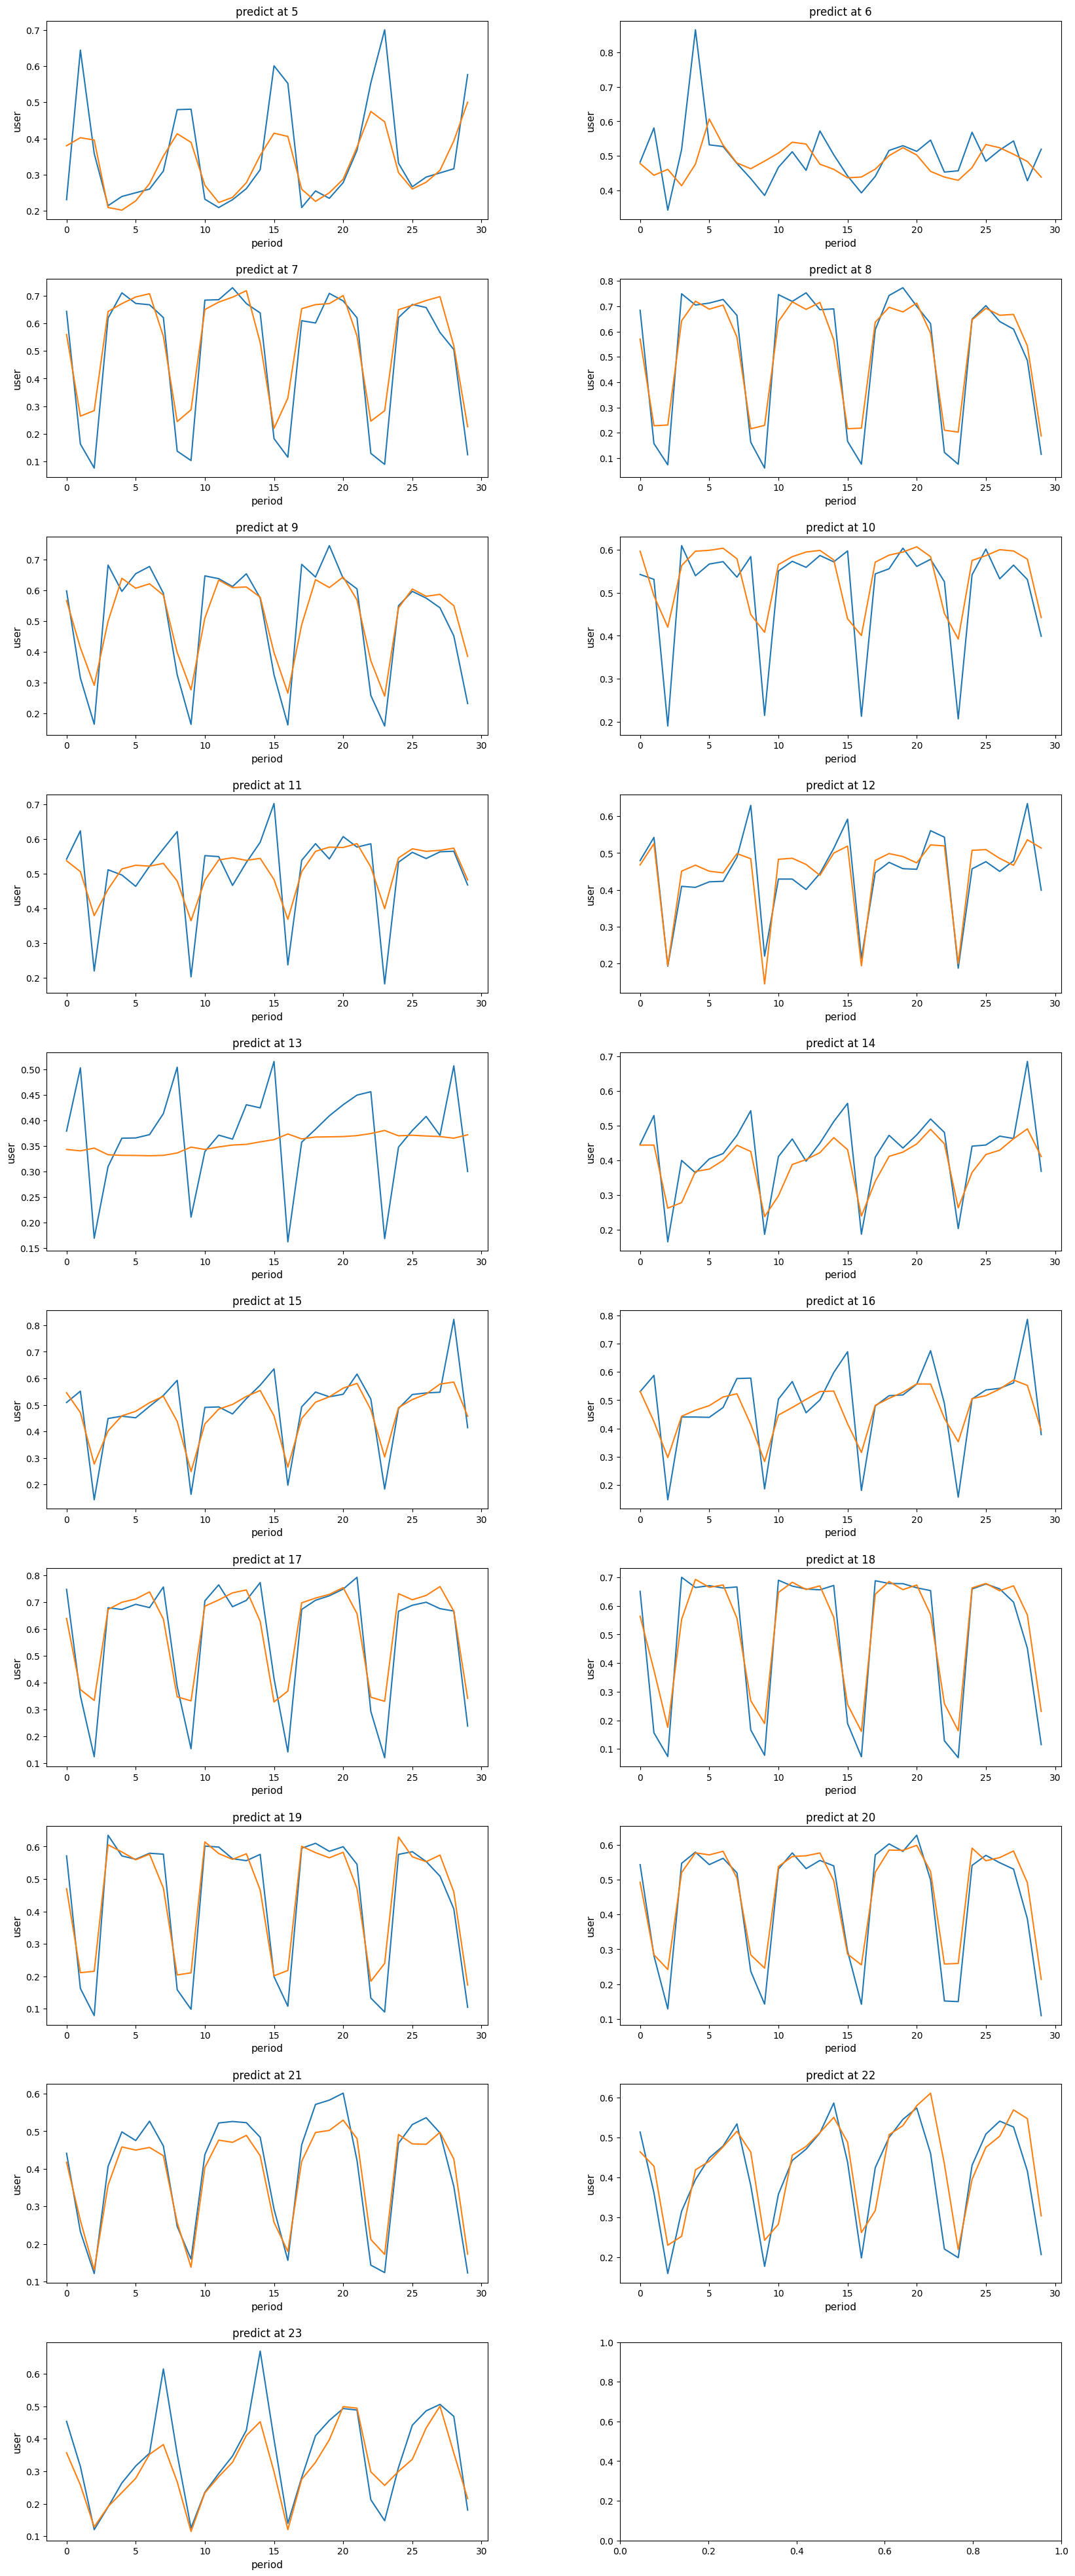

In [60]:
#10*2로 그래프 생성
fig, axes = plt.subplots(10,2)

#격자 크기 설정 및 여백 설정
fig.set_size_inches((20, 50))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

k=0

#그래프 그리는 함수 호출
for time in range(5,24):
  if time%2 != 0:
    setPredictGraph(k,0,time)
  else:
    setPredictGraph(k,1,time)
    k+=1

#그래프 보기
plt.show()

In [ ]:
preData = [0] * 24 #예측데이터를 수치로 보여주기 위해 학습 된 데이터들을 한곳에 저장
for time in enumerate(times):
    preData[int(time[1])] = eval('model'+time[1]).predict(x_test[int(time[1])])

In [62]:
#12.2에 대한 예측값이다
#정규화가 되어있으므로 값이 소수점으로 떨어진다.
print('시간     \t예측치 \t\t실제값')
for time in enumerate(times):
  print(time[1], ':\t', preData[int(time[1])][0],'\t', y_test[int(time[1])][0])

시간     	예측치 		실제값
05 :	 [0.37991488] 	 [0.23086735]
06 :	 [0.47778058] 	 [0.48180678]
07 :	 [0.55982107] 	 [0.64381592]
08 :	 [0.57042414] 	 [0.68413218]
09 :	 [0.5669836] 	 [0.59840728]
10 :	 [0.59621596] 	 [0.54230118]
11 :	 [0.5378053] 	 [0.54242518]
12 :	 [0.46778038] 	 [0.47966535]
13 :	 [0.3431262] 	 [0.37895965]
14 :	 [0.4435248] 	 [0.44601499]
15 :	 [0.54574865] 	 [0.50889416]
16 :	 [0.5314744] 	 [0.53024502]
17 :	 [0.63950795] 	 [0.74792392]
18 :	 [0.5638405] 	 [0.65080492]
19 :	 [0.47023264] 	 [0.57134323]
20 :	 [0.49235785] 	 [0.5431991]
21 :	 [0.41751048] 	 [0.44144313]
22 :	 [0.46430096] 	 [0.51392048]
23 :	 [0.35678792] 	 [0.45347698]


In [ ]:
#손실(loss) 및 평균절대오차(mae)를 저장
for time in enumerate(times):
  globals()['evaluate{}'.format(time[1])] = eval('model'+time[1]).evaluate(x_test[int(time[1])], y_test[int(time[1])], batch_size= 16)

In [64]:
# 각 시간 별 loss 및 평균절대오차 출력
for time in enumerate(times):
  print("%s시에대한 loss: %.4f\t 평균절대오차: %.4f" % (time[1],eval('evaluate'+time[1])[0],eval('evaluate'+time[1])[1]))

05시에대한 loss: 0.0082	 평균절대오차: 0.0603
06시에대한 loss: 0.0089	 평균절대오차: 0.0606
07시에대한 loss: 0.0090	 평균절대오차: 0.0736
08시에대한 loss: 0.0066	 평균절대오차: 0.0666
09시에대한 loss: 0.0080	 평균절대오차: 0.0685
10시에대한 loss: 0.0079	 평균절대오차: 0.0633
11시에대한 loss: 0.0077	 평균절대오차: 0.0604
12시에대한 loss: 0.0028	 평균절대오차: 0.0411
13시에대한 loss: 0.0096	 평균절대오차: 0.0742
14시에대한 loss: 0.0051	 평균절대오차: 0.0559
15시에대한 loss: 0.0061	 평균절대오차: 0.0532
16시에대한 loss: 0.0101	 평균절대오차: 0.0694
17시에대한 loss: 0.0095	 평균절대오차: 0.0719
18시에대한 loss: 0.0072	 평균절대오차: 0.0651
19시에대한 loss: 0.0043	 평균절대오차: 0.0493
20시에대한 loss: 0.0034	 평균절대오차: 0.0443
21시에대한 loss: 0.0023	 평균절대오차: 0.0433
22시에대한 loss: 0.0052	 평균절대오차: 0.0532
23시에대한 loss: 0.0064	 평균절대오차: 0.0540


In [65]:
#역정규화 작업
inverse_pre_df = pd.DataFrame(columns=scale_cols)

#preData[5]~preData[23]까지 하나씩 뽑아서 처음 df의 세팅과 같게 만들어준다
for i in range(0, 30):
  new_data = []
  for j in range(5,24):
    new_data.extend(preData[j][i])

  inverse_pre_df.loc[len(inverse_pre_df)] = new_data

inverse_pre_df = scaler.inverse_transform(inverse_pre_df)

#inverse_pre_df

In [66]:
inverse_Ytest_df = pd.DataFrame(columns=scale_cols) #테스트값 역정규화 dataframe

#y_test_df[5]~y_test[23]까지 하나의 df에 넣어 주어서 처음 df의 세팅과 같게 만들어준다
for i in range(0, 30):
  new_data = []
  for j in range(5,24):
    new_data.extend(y_test[j][i])

  inverse_Ytest_df.loc[len(inverse_Ytest_df)] = new_data

#역정규화 이제 에측 수치가 1아래의 숫자가 아닌 실제 예측치가 나온다.
inverse_Ytest_df = scaler.inverse_transform(inverse_Ytest_df)

#inverse_Ytest_df

In [67]:
#30일치를 정답데이터로 사용하고 예측했기 때문에
#12.2 ~ 12.31까지만 예측이 가능하다.

day = 3 #예측값을 보고싶은 날 2 ~ 31

print('12월'+str(day)+'일에 대한 예측')
print('시간     \t예측치 \t\t실제값')

day -= 2
for i in range(0, 19):
  print("%s: \t\t %.2f \t %d" %(i+5, inverse_pre_df[day][i], inverse_Ytest_df[day][i]))


12월3일에 대한 예측
시간     	예측치 		실제값
5: 		 376.28 	 566
6: 		 572.63 	 682
7: 		 753.06 	 542
8: 		 1043.13 	 806
9: 		 1447.35 	 1187
10: 		 1632.07 	 1722
11: 		 2277.45 	 2659
12: 		 3203.46 	 3275
13: 		 3165.42 	 4140
14: 		 3890.95 	 4391
15: 		 4663.96 	 5209
16: 		 5071.91 	 6351
17: 		 5912.95 	 5653
18: 		 7906.22 	 4213
19: 		 3882.74 	 3314
20: 		 3998.20 	 3975
21: 		 4705.10 	 4388
22: 		 6098.02 	 5247
23: 		 2287.36 	 2753
